In [17]:
from typing import Annotated
from typing_extensions import TypedDict

In [18]:
### Working with tools

from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

### Arxiv and Wikipedia tools

arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)

wiki_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wiki_tool = WikipediaQueryRun(api_wrapper=wiki_wrapper)

In [19]:
arxiv_tool

ArxivQueryRun(api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=1, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=300))

In [20]:
wiki_tool

WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'c:\\Users\\adity\\Desktop\\GEN AI\\.venv\\lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=1, lang='en', load_all_available_meta=False, doc_content_chars_max=300))

In [21]:
wiki_tool.invoke("What is Machine Learning?")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline'

In [22]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [23]:
tools = [arxiv_tool, wiki_tool]

In [24]:
### LangGraph Application

from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [25]:
from langgraph.graph import StateGraph, START, END

In [26]:
graph_builder = StateGraph(State)

In [27]:
import os
from dotenv import load_dotenv

load_dotenv()

groq_api_key = os.getenv('GROQ_API_KEY')

In [28]:
from langchain_groq import ChatGroq

llm = ChatGroq(groq_api_key=groq_api_key, model="Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000274246E08E0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000027425A2DD50>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [29]:
llm_with_tools = llm.bind_tools(tools=tools)

In [30]:
def chatbot(state: State):
    
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [31]:
from langgraph.prebuilt import ToolNode, tools_condition

In [32]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

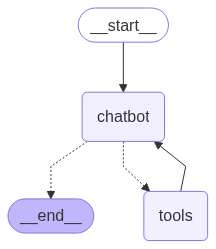

In [33]:
graph = graph_builder.compile()
graph

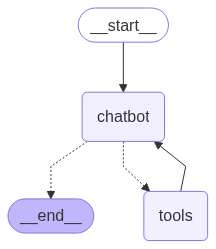

In [34]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error displaying graph: {e}")

In [35]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["exit", "quit"]:
        print("Exiting the chatbot.")
        break
    for event in graph.stream({'messages': [("user", user_input)]}, stream_mode="values"):
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Hiii, I live in India
================================== Ai Message ==================================
Tool Calls:
  wikipedia (gvcvepfzq)
 Call ID: gvcvepfzq
  Args:
    query: India
================================= Tool Message =================================
Name: wikipedia

Page: India
Summary: India, officially the Republic of India, is a country in South Asia.  It is the seventh-largest country by area; the most populous country since 2023; and, since its independence in 1947, the world's most populous democracy. Bounded by the Indian Ocean on the south, the Arabian 
================================== Ai Message ==================================

That's interesting!  What would you like to know about India?
================================ Human Message =================================

What is attention is all you need
================================== Ai Message =============================